# 1. Load pre-trained Model

In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
import os
import os.path as osp
from transglot.models.listener import *
from transglot.simple_utils import unpickle_data
import matplotlib.pyplot as plt
from PIL import Image
import hydra
import omegaconf

top_data_dir = 'data/main_data_for_chairs'
img_dir = osp.join(top_data_dir,"images/shapenet/03001627")
data_name = 'game_data.pkl'
game_data, word_to_int, int_to_word, int_to_sn_model, sn_model_to_int, sorted_sn_models = \
    unpickle_data(osp.join(top_data_dir, data_name))
vocab_size=len(int_to_word)

outputs_top_dir = "outputs"
ver_date_dir = "head_1" # head=1

# Automatically select best ckpt #
best_acc = -1
for file in os.listdir(osp.join(outputs_top_dir, f"checkpoints/{ver_date_dir}")):
    if file[-4:] != "ckpt" or file == "last.ckpt":
        continue
    val_acc = float(file[-9:-5])
    if val_acc > best_acc:
        best_acc = val_acc
        ckpt_path = osp.join(outputs_top_dir, f"checkpoints/{ver_date_dir}/{file}")
#################################

# get hyper parameters #
hparams_path = osp.join(outputs_top_dir,"logs", ver_date_dir, "hparams.yaml")
hparams = omegaconf.OmegaConf.load(hparams_path)
########################

listener = Transglot.load_from_checkpoint(ckpt_path, hparams=hparams).cuda()
listener.eval()
for p in listener.parameters():
    p.requires_grad = False

unique geometries in train/test/val 3145 393 393


# 2. Test Classification Acc

In [2]:
trainer = pl.Trainer(gpus=1,
                    checkpoint_callback=False,
                    logger=False)
trainer.test(listener)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


unique geometries in train/test/val 3145 393 393


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 78.01102447509766, 'test_loss': 0.660237729549408}
--------------------------------------------------------------------------------


[{'test_acc': 78.01102447509766, 'test_loss': 0.660237729549408}]

In [3]:
def visualize(choice, sentence=None, save=False):
    chairs, chairs_idx, targets, padded_token = listener.test_ds[choice]
    chairs, chairs_idx = chairs.unsqueeze(0), torch.tensor(chairs_idx).unsqueeze(0)
    
    if sentence is not None:
        token = sentence.split(" ")
        token = np.array([word_to_int[token] for token in token])
        pad_cnt = 34 - len(token)
        padded_token = np.pad(token, (0, pad_cnt), "constant", constant_values=0)
    
    padded_token = torch.tensor(padded_token).unsqueeze(0)
    ############ Run the Model ############
    listener.eval()
    outputs = listener(chairs.cuda(), chairs_idx.cuda(), padded_token.cuda())
    #######################################
    
    chairs = chairs[0].cpu().numpy()
    pred = outputs["logits"][0].max(-1)[1].cpu().numpy()
    answer = targets
    attn_map = torch.cat(outputs["attn_weights"][0], 0).cpu().numpy() #[3, num_head, 2048]
    
    token = padded_token[0].cpu().numpy()

    sentence = [int_to_word[t] for t in token]
    sentence = " ".join([s for s in sentence if s != "<EOS>"])

    ca, cb, cc = chairs_idx[0].tolist()
    ca, cb, cc = int_to_sn_model[ca], int_to_sn_model[cb], int_to_sn_model[cc]
    ca_name, cb_name, cc_name = os.listdir(osp.join(img_dir, ca))[0], \
                                os.listdir(osp.join(img_dir, cb))[0], \
                                os.listdir(osp.join(img_dir, cc))[0]
    ca, cb, cc = osp.join(img_dir, ca, ca_name), osp.join(img_dir, cb, cb_name), osp.join(img_dir, cc, cc_name)
    ca, cb, cc = Image.open(ca), Image.open(cb), Image.open(cc)
    chair_img = [ca, cb, cc]

    total_head = hparams["num_heads"]
    plt.rcParams["image.cmap"]="viridis"
    
    fig = plt.figure(figsize=(6*3, 6*(total_head+1)), facecolor="white")
    fig.suptitle(f"Sentence: \"{sentence}\"\npred: {pred} | answer: {answer}", fontsize=25)
    for i in range(3):
        ax = fig.add_subplot(2, 3, i+1, projection="3d")
        ax.scatter(chairs[i,:,0], chairs[i,:,2], chairs[i,:,1], c=attn_map[i,0])
        ax.set_xlim(-0.3,0.3)
        ax.set_ylim(-0.3,0.3)
        ax.set_zlim(-0.3,0.3)
        ax.view_init(elev=25, azim=-25)
        ax.axis("off")
        
        ax = fig.add_subplot(2,3,i+4)
        ax.imshow(chair_img[i])
        ax.axis("off")
                
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    if save:
        plt.savefig(f"img/{choice}.png")
    del(fig)
    


# 3. Visualize Attention Maps
## Choose the game number and make your own sentence!
(only lowercase available.)

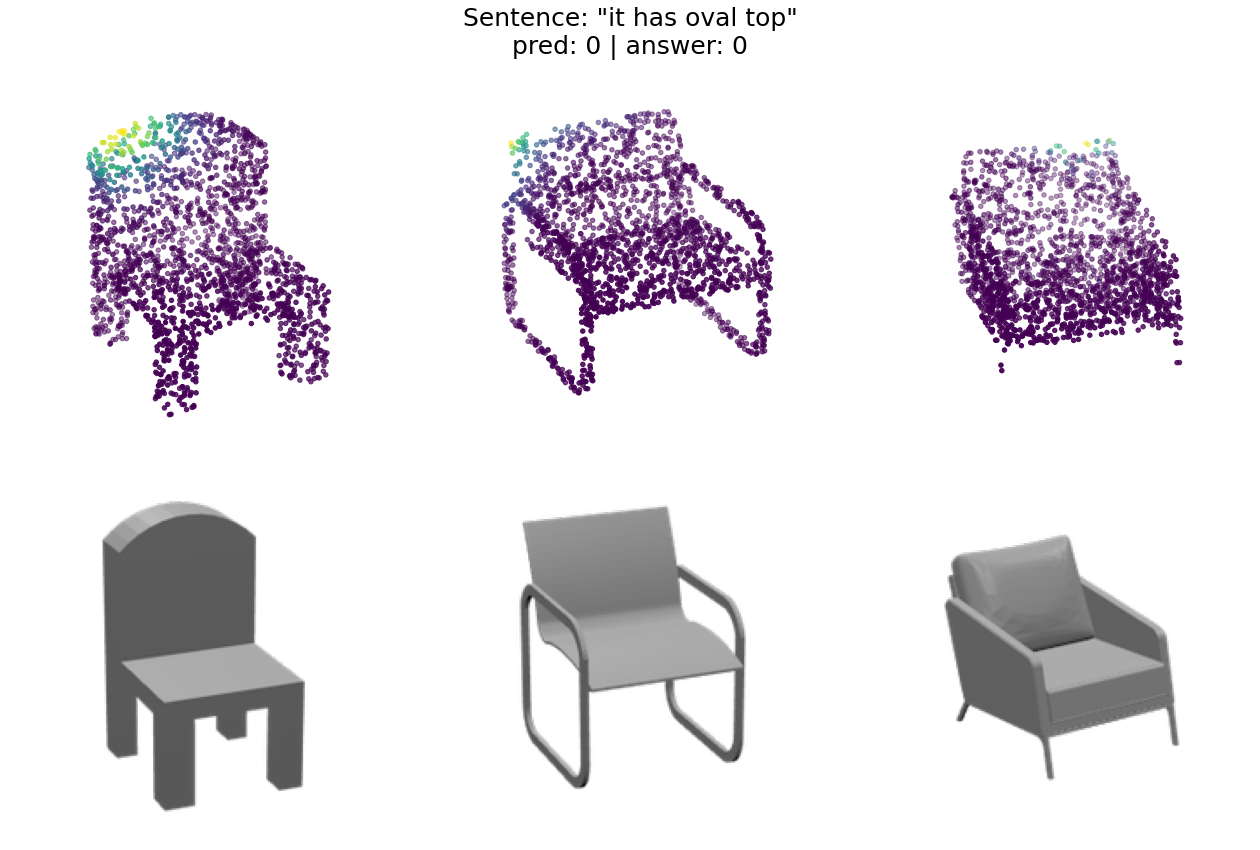

In [8]:
visualize(choice=159, sentence="it has oval top")